<a href="https://colab.research.google.com/github/DannyTheFlower/PDA_Course/blob/main/labs/lab_2/PDA_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from gensim.utils import simple_preprocess
import numpy as np
import gensim.parsing.preprocessing as pp
from gensim.models import Word2Vec, KeyedVectors
import gensim

from pymystem3 import Mystem # для лемматизации
m = Mystem()

# Постановка задачи (на практику 4) и загрузка данных

В рамках практики по обработке текста поработаем с реальными данными, содержательно близкими к данным с первой практики, - из Конструктора ОП. В этот раз поработаем с описанием дисциплин с помощью языковых моделей.


Задача на практику - предобработать датасет:
1. получить текстовое описание каждой дисциплины датасета
2. выполнить предобработку текстовых данных
3. построить для дисциплины вектор на основе word2vec
4. потестировать текстовые представления

Задач не много, но все затратные по времени.

In [2]:
!gdown 1onuImgIOYhiqwnBuFsDnvepD2R5Gkebi

Downloading...
From: https://drive.google.com/uc?id=1onuImgIOYhiqwnBuFsDnvepD2R5Gkebi
To: /content/df_up_courses_202308.csv
100% 1.88G/1.88G [00:21<00:00, 86.4MB/s]


Из информации о дисциплине у нас есть следующая:
1. course_id - номер дисциплины (может повторяться)
2. course_title - название дисциплины
3. description - краткое описание дисциплины
4. section - разделы дисциплины
5. topic - темы, входящие в раздел дисциплины
6. qualification - уровень образования (бакалавриат, магистратура, специалитет)
7. unit_id - айди факульета
8. up_id - айди учебного плана (образовательной прогарммы)
9. up_title - название учебного плана (образовательной программы)
10. start_year - год набора
11. module_name - название модуля, в который входит дисциплина

In [3]:
df = pd.read_csv("/content/df_up_courses_202308.csv")

In [4]:
df.head()

,Unnamed: 0,course_id,course_title,description,section,topic,qualification,unit_id,up_id,up_title,start_year,module_name
0,0,2811,Архитектура информационных систем,Целью освоения дисциплины «Архитектура информа...,Функциональная и информационная архитектуры,"Понятия ИС, КИС, АСУ, АСУП. ИС как инструмент ...",bachelor,14.0,6905,Программирование и интернет-технологии,2018,"Специализация ""Информационные системы и технол..."
1,1,2811,Архитектура информационных систем,Целью освоения дисциплины «Архитектура информа...,Функциональная и информационная архитектуры,"Понятия ИС, КИС, АСУ, АСУП. ИС как инструмент ...",bachelor,14.0,6938,Программирование и интернет-технологии,2019,"Специализация ""Информационные системы и технол..."
2,2,2811,Архитектура информационных систем,Целью освоения дисциплины «Архитектура информа...,Функциональная и информационная архитектуры,"Понятия ИС, КИС, АСУ, АСУП. ИС как инструмент ...",bachelor,14.0,7014,Программирование и интернет-технологии,2020,"Специализация ""Разработка информационных систе..."
3,54,2811,Архитектура информационных систем,Целью освоения дисциплины «Архитектура информа...,Функциональная и информационная архитектуры,Различные методики управления организацией,bachelor,14.0,6905,Программирование и интернет-технологии,2018,"Специализация ""Информационные системы и технол..."
4,55,2811,Архитектура информационных систем,Целью освоения дисциплины «Архитектура информа...,Функциональная и информационная архитектуры,Различные методики управления организацией,bachelor,14.0,6938,Программирование и интернет-технологии,2019,"Специализация ""Информационные системы и технол..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039709 entries, 0 to 1039708
Data columns (total 12 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Unnamed: 0     1039709 non-null  int64  
 1   course_id      1039709 non-null  int64  
 2   course_title   1039709 non-null  object 
 3   description    1038033 non-null  object 
 4   section        1039709 non-null  object 
 5   topic          1039709 non-null  object 
 6   qualification  1039709 non-null  object 
 7   unit_id        1039709 non-null  float64
 8   up_id          1039709 non-null  int64  
 9   up_title       1039709 non-null  object 
 10  start_year     1039709 non-null  int64  
 11  module_name    1039709 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 95.2+ MB


## Предобработка датасета

Преобразуйте датасет так, чтобы одна строка описывала одну дисциплину в учебном плане. Отдельным столбцом должен храниться весь текст, который описывает дисциплину: description, section, topic. Без дубликатов содержания разделов и тем внутри дисциплины.

Сгруппируем данные таким образом, чтобы объединить текстовые поля для каждой уникальной дисциплины (по course_id и up_id). Исключаем NaN значения и преобразуем все в строки перед объединением. Присоединяем тексты, удаляем дубликаты, разделяем их символом новой строки.

In [22]:
def aggregate_texts(series):
    valid_texts = [str(text) for text in series if pd.notnull(text)]
    return '. '.join(set(valid_texts))

df_aggregated = df.groupby(['course_id', 'up_id']).agg({
    'description': aggregate_texts,
    'section': aggregate_texts,
    'topic': aggregate_texts,
    'course_title': 'first',
    'qualification': 'first',
    'unit_id': 'first',
    'up_title': 'first',
    'start_year': 'first',
    'module_name': 'first'
}).reset_index()

Теперь создадим новый столбец, который объединяет тексты из description, section и topic

In [26]:
df_aggregated['full_description'] = df_aggregated[['course_title', 'description', 'section', 'topic']].apply(lambda x: '. '.join(x), axis=1)

Мы можем удалить старые текстовые столбцы, так как они больше не нужны

In [27]:
df_final = df_aggregated.drop(columns=['description', 'section', 'topic'])

Проверим результат

In [28]:
df_final

,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description
0,2626,6905,Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...
1,2626,6938,Философия,bachelor,8.0,Программирование и интернет-технологии,2019,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...
2,2626,6974,Философия,bachelor,8.0,Информатика и программирование,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...
3,2626,7014,Философия,bachelor,8.0,Программирование и интернет-технологии,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...
4,2626,7136,Философия,bachelor,8.0,Информатика и программирование,2021,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...
...,...,...,...,...,...,...,...,...,...
63964,25731,7255,Основы планирования научных исследований и упр...,master,63.0,Физика и технология наноструктур / Physics and...,2022,Обязательные дисциплины (RU),Основы планирования научных исследований и упр...
63965,25732,7255,Основы планирования научных исследований и упр...,master,63.0,Физика и технология наноструктур / Physics and...,2022,Обязательные дисциплины (EN),Основы планирования научных исследований и упр...
63966,25773,7236,Дифференциальные уравнения,bachelor,51.0,Фотоника и оптоинформатика,2022,Обязательные дисциплины ОП,Дифференциальные уравнения. Дифференциальные у...
63967,30918,7201,Функциональная безопасность киберфизических си...,master,13.0,Функциональная безопасность беспилотных трансп...,2022,Обязательные дисциплины,Функциональная безопасность киберфизических си...


Преобразования выполняются не слишком быстро, рекомендую сохраниться.

In [29]:
df_final.to_csv('transformed_dataset.csv', index=False)

## Предобработка описания дисциплины

Пора поработать со столбцом с текстовым содержанием дисциплины. Минимально понадобятся следующие шаги предобработки:
1. Токенизация
2. Удаление пунктуации
3. Лемматизация
4. Удаление лишних пробелов внутри текста

Чтобы не слишком углубляться в предобработку, рекомендую воспользоваться реализованными в gensim методами. Примеры можно найти в ноутбуке по ссылке: https://colab.research.google.com/drive/1Lxe0_dPxF5_nNC1hnHTRc01rnMmUVCXa?usp=sharing

In [31]:
pre_df = pd.read_csv('transformed_dataset.csv')

In [32]:
pre_df.shape

(63969, 9)

In [33]:
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63969 entries, 0 to 63968
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   course_id         63969 non-null  int64  
 1   up_id             63969 non-null  int64  
 2   course_title      63969 non-null  object 
 3   qualification     63969 non-null  object 
 4   unit_id           63969 non-null  float64
 5   up_title          63969 non-null  object 
 6   start_year        63969 non-null  int64  
 7   module_name       63969 non-null  object 
 8   full_description  63969 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 4.4+ MB


In [ ]:
!pip install pymorphy2

In [51]:
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
import string
from nltk.corpus import stopwords
import pymorphy2

In [44]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [53]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
analyzer = pymorphy2.MorphAnalyzer()

In [41]:
def text_to_wordlist(text, remove_stopwords=True):
    text = re.sub("[^а-яА-ЯёЁa-zA-Z&]"," ", text)

    words = text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("russian") + stopwords.words("english"))
        words = [w for w in words if not w in stops]
    norm_words = [analyzer.parse(word)[0].normal_form for word in words]
    return norm_words

In [39]:
pre_df['processed_description'] = pre_df['full_description'].apply(text_to_wordlist)

In [40]:
pre_df

,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description
0,2626,6905,Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...,"[философия, курс, философия, давать, целостный..."
1,2626,6938,Философия,bachelor,8.0,Программирование и интернет-технологии,2019,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"[философия, курс, философия, давать, целостный..."
2,2626,6974,Философия,bachelor,8.0,Информатика и программирование,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"[философия, курс, философия, давать, целостный..."
3,2626,7014,Философия,bachelor,8.0,Программирование и интернет-технологии,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"[философия, курс, философия, давать, целостный..."
4,2626,7136,Философия,bachelor,8.0,Информатика и программирование,2021,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"[философия, курс, философия, давать, целостный..."
...,...,...,...,...,...,...,...,...,...,...
63964,25731,7255,Основы планирования научных исследований и упр...,master,63.0,Физика и технология наноструктур / Physics and...,2022,Обязательные дисциплины (RU),Основы планирования научных исследований и упр...,"[основа, планирование, научный, исследование, ..."
63965,25732,7255,Основы планирования научных исследований и упр...,master,63.0,Физика и технология наноструктур / Physics and...,2022,Обязательные дисциплины (EN),Основы планирования научных исследований и упр...,"[основа, планирование, научный, исследование, ..."
63966,25773,7236,Дифференциальные уравнения,bachelor,51.0,Фотоника и оптоинформатика,2022,Обязательные дисциплины ОП,Дифференциальные уравнения. Дифференциальные у...,"[дифференциальный, уравнение, дифференциальный..."
63967,30918,7201,Функциональная безопасность киберфизических си...,master,13.0,Функциональная безопасность беспилотных трансп...,2022,Обязательные дисциплины,Функциональная безопасность киберфизических си...,"[функциональный, безопасность, киберфизический..."


In [41]:
df_final['full_description'].iloc[0]

'Философия. Курс «Философия» даёт целостное представление о специфике философии как актуальной формы мышления, о месте и роли философствования в различных средах: повседневной, социальной, коммуникационной, научной.Этот курс для тех, кто хочет узнать, к примеру, о том, что осталось в нашем мышлении неизменным со времен античности, и почему наука, какой мы знаем ее сегодня, не появилась бы без Декарта. Философия для тех, кому важно знать, как избавиться от ошибочных суждений, развить критическое мышление и попробовать себя в роли мастера аргументации в режиме и оффлайн, и онлайн.. Соматическая определенность мышления. Структуры мышления. Мышление и предметный мир. Социальная определенность мышления. Телесность и аффективность в мышлении.. Критическое мышление как задача философии, науки, искусства, повседневных практик.. Способы и границы систематизации предметов мышления: логика, категориальные структуры.. Нейронаука о мышлении и сознании человека. Проблемы биополитики.. Антропоцентриз

In [42]:
pre_df['processed_description'].iloc[0]

['философия',
 'курс',
 'философия',
 'давать',
 'целостный',
 'представление',
 'специфика',
 'философия',
 'актуальный',
 'форма',
 'мышление',
 'место',
 'роль',
 'философствование',
 'различный',
 'среда',
 'повседневный',
 'социальный',
 'коммуникационный',
 'научный',
 'курс',
 'тот',
 'хотеть',
 'узнать',
 'пример',
 'остаться',
 'наш',
 'мышление',
 'неизменный',
 'время',
 'античность',
 'почему',
 'наука',
 'знать',
 'сегодня',
 'появиться',
 'декарт',
 'философия',
 'тот',
 'кто',
 'важно',
 'знать',
 'избавиться',
 'ошибочный',
 'суждение',
 'развить',
 'критический',
 'мышление',
 'попробовать',
 'роль',
 'мастер',
 'аргументация',
 'режим',
 'офлайн',
 'онлайн',
 'соматический',
 'определённость',
 'мышление',
 'структура',
 'мышление',
 'мышление',
 'предметный',
 'мир',
 'социальный',
 'определённость',
 'мышление',
 'телесность',
 'аффективность',
 'мышление',
 'критический',
 'мышление',
 'задача',
 'философия',
 'наука',
 'искусство',
 'повседневный',
 'практика',
 '

Не будет лишним в этот момент сохраниться. Лемматизация выполняется сравнительно долго.

In [43]:
pre_df.to_csv('tokenized_dataset.csv', index=False)

Далее обучим модель Word2Vec для получения эмбеддингов описаний дисциплины.

In [46]:
model = Word2Vec(pre_df.processed_description.tolist(), min_count=5, vector_size=300, workers=4, window=10)

Сохраним обученную модель.

In [47]:
model_path = "op_w2v"
model.save(model_path)

Посмотрим полученный вектор.

In [48]:
model.wv.get_vector("обучение")

array([-3.7946947 ,  2.1676989 ,  3.87688   , -4.348506  , -5.18349   ,
        0.355687  ,  5.2747154 , -0.01001083,  2.40639   ,  5.2152076 ,
       -1.3233546 , -1.2802994 ,  5.5626154 ,  1.652657  ,  2.4082713 ,
       -0.15900299,  1.5078481 ,  2.6510668 ,  2.3725922 ,  4.270508  ,
       -2.1649694 ,  0.45628363, -5.777483  , -3.936162  ,  1.1863049 ,
        0.51794255, -2.8545117 ,  3.4434865 ,  0.46622238,  0.3097376 ,
       -5.8205295 , -3.7761686 ,  2.5373182 ,  3.585165  , -0.25817055,
       -1.3679944 , -0.10033846,  1.2846544 ,  2.5329087 ,  3.666508  ,
        8.491078  ,  4.958943  , -5.5734944 ,  1.9952881 ,  2.5807285 ,
       -2.832535  ,  1.1300126 , -2.046128  ,  1.3591429 , -6.7967153 ,
        5.2832737 , -1.0755453 , -0.7362062 ,  1.1835595 ,  2.6954424 ,
        1.4522196 , -3.8856018 ,  3.5800393 ,  3.6305153 , -0.7982123 ,
        1.6611463 , -1.8734745 , -0.32491928,  5.184568  ,  2.3554535 ,
       -2.5271263 ,  0.8033313 ,  3.6005747 ,  4.995247  , -2.17

Посмотрим слова, наиболее близкие к "машинному обучению".

In [49]:
model.wv.most_similar(["обучение", "машинный"])

[('дикторский', 0.4575808048248291),
 ('кластеризация', 0.42500603199005127),
 ('мо', 0.42051422595977783),
 ('нейросетевой', 0.41029277443885803),
 ('регрессия', 0.4046062231063843),
 ('регрессионный', 0.39025482535362244),
 ('предобработка', 0.38576382398605347),
 ('аугментация', 0.38441047072410583),
 ('покрывать', 0.37958067655563354),
 ('сигмоидальный', 0.3691387474536896)]

Вероятно, наиболее тесная связь машинного обучения в описании РПД оказалась именно в описании курса "Распознавание диктора".

In [68]:
pre_df[pre_df["course_title"] == "Распознавание диктора"]

,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding
15432,11220,7007,Распознавание диктора,master,14.0,Речевые информационные системы,2020,"Специализация ""Речевые информационные системы""",Распознавание диктора. Целью освоения дисципли...,"[распознавание, диктор, цель, освоение, дисцип...","[-0.39349097, -0.5428325, -0.16230409, -0.0648..."
15433,11220,7132,Распознавание диктора,master,14.0,Речевые информационные системы,2021,"Специализация ""Речевые информационные системы""",Распознавание диктора. Целью освоения дисципли...,"[распознавание, диктор, цель, освоение, дисцип...","[-0.39349097, -0.5428325, -0.16230409, -0.0648..."
37661,17958,7187,Распознавание диктора,master,14.0,Речевые технологии и машинное обучение,2022,Технологии обработки звучащей речи,Распознавание диктора. Целью освоения дисципли...,"[распознавание, диктор, цель, освоение, дисцип...","[-0.34792495, -0.544846, -0.20985654, -0.09122..."


Определим функцию, которая возвращает вектор дисциплины как усреднённый вектор слов, встречающихся в описании дисциплины.

In [56]:
def embed(tokens, w2v_model):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if len(vectors) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(vectors, axis=0)

In [24]:
# Посмотрим такой вектор для первой строки в датафрейме
embed(pre_df['processed_description'].iloc[0], model)

array([ 0.5146656 , -0.39826688, -0.09235437,  0.02301925, -0.35211957,
       -0.46042582, -0.2974566 , -0.5485314 ,  0.18123344,  0.14167611,
       -0.46832272, -0.30773854, -0.4940585 ,  0.55763483,  0.19114023,
        0.22597206,  0.7133206 , -0.05989781, -0.43902966, -0.1433654 ,
       -0.77421594,  0.01347816,  0.34019342, -0.43678027, -0.30845258,
        0.7408545 ,  0.03181175, -0.45303932,  0.6017392 ,  0.19696508,
        0.776134  , -0.33738232, -0.09025973, -0.31096563,  0.07827503,
        0.17405145, -0.68905187,  0.6208572 , -0.02171864,  0.9467616 ,
       -0.24168625, -0.4804898 , -0.51288486, -0.24114421, -0.32833406,
       -0.03276691,  0.20041566, -0.5606652 ,  0.39341003,  0.5706958 ,
       -0.09199747, -0.02089381, -0.50839597, -0.16884269,  0.531675  ,
       -0.37753043, -0.12570965, -0.13424091,  0.07769013, -0.18019027,
       -0.395135  , -0.41651732,  0.19356781,  0.17997374, -0.40187186,
       -0.33823887,  0.35731184,  0.1315209 ,  0.02685732,  0.34

In [25]:
pre_df["embedding"] = pre_df['processed_description'].apply(lambda x: embed(x, model))
pre_df

,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding
0,2626,6905,Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[0.5146656, -0.39826688, -0.09235437, 0.023019..."
1,2626,6938,Философия,bachelor,8.0,Программирование и интернет-технологии,2019,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[0.5146656, -0.39826688, -0.09235437, 0.023019..."
2,2626,6974,Философия,bachelor,8.0,Информатика и программирование,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[0.5146656, -0.39826688, -0.09235437, 0.023019..."
3,2626,7014,Философия,bachelor,8.0,Программирование и интернет-технологии,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[0.5146656, -0.39826688, -0.09235437, 0.023019..."
4,2626,7136,Философия,bachelor,8.0,Информатика и программирование,2021,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[0.5146656, -0.39826688, -0.09235437, 0.023019..."
...,...,...,...,...,...,...,...,...,...,...,...
63964,25731,7255,Основы планирования научных исследований и упр...,master,63.0,Физика и технология наноструктур / Physics and...,2022,Обязательные дисциплины (RU),Основы планирования научных исследований и упр...,"['основа', 'планирование', 'научный', 'исследо...","[0.45906574, -0.30122405, -0.15150651, 0.09387..."
63965,25732,7255,Основы планирования научных исследований и упр...,master,63.0,Физика и технология наноструктур / Physics and...,2022,Обязательные дисциплины (EN),Основы планирования научных исследований и упр...,"['основа', 'планирование', 'научный', 'исследо...","[0.1612777, -0.85968286, 0.41190237, 0.3332886..."
63966,25773,7236,Дифференциальные уравнения,bachelor,51.0,Фотоника и оптоинформатика,2022,Обязательные дисциплины ОП,Дифференциальные уравнения. Дифференциальные у...,"['дифференциальный', 'уравнение', 'дифференциа...","[0.4251978, -0.34754595, -0.14475505, 0.095401..."
63967,30918,7201,Функциональная безопасность киберфизических си...,master,13.0,Функциональная безопасность беспилотных трансп...,2022,Обязательные дисциплины,Функциональная безопасность киберфизических си...,"['функциональный', 'безопасность', 'киберфизич...","[0.30166072, -0.30429664, -0.11321099, 0.10357..."


Сохраним финальную версию датафрейма.

In [69]:
pre_df.to_csv("embed_dataset.csv", index=False)

# Задание на ЛР2

С предобработанными данными попытаемся решить следующие задачи:

1. Определить предметные области дисциплин через кластеризацию. Используем два классических алгоритма: k-means и иерархическую кластеризацию.
2. Найти дисциплины, которые выбиваются из учебного плана. Для этого построим эмбеддинг учебного плана (усредним эмбеддинги всех его дисциплин) и найдем дисциплины, у которых минимальное косинусное сходство с эмбеддингом учебного плана. В какие модули входят эти дисциплины?
3. Оценить, насколько удачно будет генерировать содержание дисциплины LLM. Структура описания дисциплины не важна. Важно содержание. Сравнивать будем эмбеддинги снова через косинусное сходство.

## Кластеризация дисциплин

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path_to_df = "/content/drive/MyDrive/data_for_labs/embed_dataset.csv"

In [4]:
df = pd.read_csv(path_to_df)

Векторы, представленные изначально в качестве списков, при сохранении преобразовались в строку. Им необходимо вернуть изначальный вид.

In [5]:
def str_to_list(vector_str):
    numbers_str = re.findall(r"[-+]?\d*\.\d+|\d+", vector_str)
    vector_list = [float(num) for num in numbers_str]
    return vector_list

df["embedding"] = df["embedding"].apply(str_to_list).apply(lambda x: x[:300])
df["full_description"] = df["full_description"].apply(lambda x: x.replace('..', '.'))

Удалим дубликаты, поскольку нас интересует только содержательный аспект в данной задаче.

In [20]:
df_to_clust = df.drop_duplicates(subset=["course_id"], keep="first")
f"{df.shape} -> {df_to_clust.shape}"

'(63969, 11) -> (7118, 11)'

In [10]:
X = np.array(df_to_clust['embedding'].tolist())

### k-means

7к объектов - небольшое количество для кластеризации, обучение будет проходить достаточно быстро. Начнем с k-means. В качестве меры сходства будем использовать косинусное расстояние. Другие виды расстояния будут мало репрезентативны на векторах размером 300.

In [40]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10,           # ни на чем не основанное предположение, что у нас 10 кластеров
                random_state=0,
                n_init="auto",
                algorithm="lloyd").fit(X) # lloyd означает, что возьмем не совсем k-means, а ЕМ - более общую версию алгоритма
kmeans.labels_

array([8, 8, 4, ..., 8, 8, 2], dtype=int32)

In [41]:
df_to_clust["cluster"] = kmeans.labels_

<ipython-input-41-9d0e96553b6d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_clust["cluster"] = kmeans.labels_


In [42]:
df_to_clust.cluster.value_counts()

8    3451
2     556
0     518
1     507
9     413
4     410
5     369
3     354
6     324
7     216
Name: cluster, dtype: int64

В отличие от исходного примера, разбиение на кластеры не получилось равномерным. Посмотрим на случайных подвыборках, по какому принципу произошло разбиение на кластеры.

In [44]:
for i in range(kmeans.n_clusters):
  display(df_to_clust.loc[df_to_clust.cluster == i].sample(n=5))

,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding,cluster
14929,11055,6861,Технологическое прогнозирование и маркетинг / ...,master,28.0,Молекулярная биология и биотехнология / Molecu...,2021,Факультативные дисциплины,Технологическое прогнозирование и маркетинг / ...,"['технологический', 'прогнозирование', 'маркет...","[6.40589178, 1.0, -6.44044399, 1.0, -1.0209491...",0
34716,16505,7022,Фотоника / Photonics,master,4.0,Прикладная оптика,2020,Межпрофильный модуль факультета,Фотоника / Photonics. The discipline is devote...,"['фотоник', 'photonics', 'discipline', 'devote...","[3.77229959, 1.0, -6.98999763, 1.0, 1.30184919...",0
40004,19763,7248,Мастерская II / Artistic Studio II,master,15.0,Искусство и наука / Art & Science,2022,Мастерские по выбору,Мастерская II / Artistic Studio II. The studen...,"['мастерская', 'ii', 'artistic', 'studio', 'ii...","[8.46054733, 1.0, -1.13933098, 0.0, 1.54634371...",0
42176,21198,7216,Дизайн продукта с заданными свойствами / Desig...,master,11.0,ФудТех / Foodtech,2022,Трек 2. Обязательные англоязычные дисциплины,Дизайн продукта с заданными свойствами / Desig...,"['дизайн', 'продукт', 'задать', 'свойство', 'd...","[5.73007405, 1.0, -8.69713962, 1.0, -1.3399662...",0
16830,12576,6980,Регулирование разработок в Life Sciences / Reg...,master,1.0,Инновационное предпринимательство / Innovation...,2021,"Специализация ""Предпринимательство в секторе L...",Регулирование разработок в Life Sciences / Reg...,"['регулирование', 'разработка', 'life', 'scien...","[1.09012938, 0.0, -8.5512507, 1.0, -3.78013253...",0


,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding,cluster
27498,15400,7151,Методы и средства измерений,master,13.0,Функциональная безопасность беспилотных трансп...,2021,Факультативные дисциплины,Методы и средства измерений. В рамках данного ...,"['метод', 'средство', 'измерение', 'рамка', 'д...","[-4.78343159, 1.0, -6.08205378, 1.0, -6.689178...",1
14855,10957,6889,Введение в теорию электрических цепей,bachelor,3.0,Техническая физика,2019,"Специализация ""Физика и техника беспроводных с...",Введение в теорию электрических цепей. Курс «В...,"['введение', 'теория', 'электрический', 'цепь'...","[-6.9037503, 1.0, -9.24368978, 1.0, -2.8841009...",1
27888,15500,6963,Прикладная радиотехника,bachelor,3.0,Прикладная и теоретическая физика,2021,Профильный профессиональный модуль,Прикладная радиотехника. Обучающиеся научатся ...,"['прикладной', 'радиотехник', 'обучаться', 'на...","[-3.14234316, 1.0, 1.42583415, 1.0, -5.0398528...",1
39307,19411,7239,Физика твердого тела,bachelor,3.0,Прикладная и теоретическая физика,2022,Теория твёрдого тела,Физика твердого тела. Цель курса – представить...,"['физика', 'твёрдый', 'тело', 'цель', 'курс', ...","[-4.9496749, 1.0, -4.89051521, 1.0, -2.3744326...",1
17306,12926,6951,Вентильно-индукторый привод энергетических систем,master,2.0,Электроинженерия,2021,"Специализация ""Преобразовательные устройства э...",Вентильно-индукторый привод энергетических сис...,"['вентильный', 'индукторый', 'привод', 'энерге...","[-6.72609985, 1.0, -7.9395932, 1.0, -3.3296409...",1


,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding,cluster
6460,4544,7035,Проектирование интеллектуальных мобильных прил...,bachelor,17.0,Мобильные и сетевые технологии,2020,"Специализация ""Интеллектуальные мобильные прил...",Проектирование интеллектуальных мобильных прил...,"['проектирование', 'интеллектуальный', 'мобиль...","[-8.97885978, 1.0, -6.59225047, 1.0, 5.4948668...",2
34504,16313,7110,Управление развитием государственных информаци...,master,30.0,Умный город и урбанистика,2021,"Специализация ""Управление государственными инф...",Управление развитием государственных информаци...,"['управление', 'развитие', 'государственный', ...","[-4.16985899, 1.0, -5.80740392, 1.0, -3.001166...",2
37836,18219,7200,Проектный менеджмент в инфокоммуникационных си...,master,17.0,Инфокоммуникации и цифровые медиа / Infocommun...,2022,Модуль Программирование и инфокоммуникации,Проектный менеджмент в инфокоммуникационных си...,"['проектный', 'менеджмент', 'инфокоммуникацион...","[-5.29602289, 1.0, -2.70748466, 1.0, -2.490351...",2
17013,12788,6949,Разработка систем поддержки принятия решений,master,17.0,Мобильные и облачные технологии,2021,"Специализация ""Искусственный интеллект в мобил...",Разработка систем поддержки принятия решений. ...,"['разработка', 'система', 'поддержка', 'принят...","[-1.0208162, 2.0, 5.2174324, 1.0, -2.6987275, ...",2
17506,13095,7148,Анализ и управление бизнес-процессами,master,1.0,Стратегии и технологии цифровой трансформации,2021,"Специализация ""IT-консалтинг: стратегии и инст...",Анализ и управление бизнес-процессами. Студент...,"['анализ', 'управление', 'бизнес', 'процесс', ...","[-9.2120409, 1.0, 9.19585884, 1.0, -7.35746324...",2


,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding,cluster
28161,15702,6956,Биотехнологические основы фундаментальной биол...,bachelor,28.0,Биотехнология,2021,Модуль обязательных дисциплин,Биотехнологические основы фундаментальной биол...,"['биотехнологический', 'основа', 'фундаменталь...","[1.58022955, 1.0, 7.86334991, 1.0, -2.26070061...",3
39267,19306,7237,Основы химии,bachelor,5.0,Лазерные технологии,2022,Обязательные дисциплины модуля,"Основы химии. Курс ""Основы химии"" является баз...","['основа', 'химия', 'курс', 'основа', 'химия',...","[-9.10591707, 2.0, -1.08085304, 1.0, -3.666758...",3
10672,7222,6860,Материаловедение,bachelor,6.0,Информационные технологии в энергетике,2018,Общепрофессиональный модуль,Материаловедение. Материаловедение - область з...,"['материаловедение', 'материаловедение', 'обла...","[-4.03240062, 2.0, -4.41881508, 1.0, -6.181550...",3
14481,10642,6917,Молекулярное моделирование биополимеров,bachelor,11.0,Биотехнология,2019,"Специализация ""Молекулярные пищевые технологии""",Молекулярное моделирование биополимеров. Курс ...,"['молекулярный', 'моделирование', 'биополимер'...","[4.00076121, 1.0, 4.87480521, 1.0, -8.73556316...",3
38393,18702,7216,Устойчивые пищевые технологии,master,11.0,ФудТех / Foodtech,2022,Специализация: Ответственное производство,Устойчивые пищевые технологии. Дисциплина посв...,"['устойчивый', 'пищевой', 'технология', 'дисци...","[2.84944147, 1.0, 1.58573836, 1.0, -2.11809203...",3


,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding,cluster
36725,17705,7177,Верификация систем ИИ,master,49.0,Глубокое обучение и генеративный искусственный...,2022,Математико-алгоритмические основы ИИ,Верификация систем ИИ. Данный курс будет фокус...,"['верификация', 'система', 'ия', 'данный', 'ку...","[4.03815918, 2.0, -2.24287465, 1.0, -6.8813264...",4
5414,4032,6929,Прикладное программирование,bachelor,14.0,Информатика и программирование,2019,"Специализация ""Информатика""",Прикладное программирование. В ходе обучения н...,"['прикладной', 'программирование', 'ход', 'обу...","[2.98401713, 2.0, 3.16243351, 1.0, -5.83861113...",4
9609,5607,7015,Моделирование сложных систем,master,12.0,Программное обеспечение радиоэлектронных систем,2020,Профессиональный модуль,Моделирование сложных систем. Целью изучения д...,"['моделирование', 'сложный', 'система', 'цель'...","[-1.00410545, 0.0, -5.50607979, 1.0, -4.788930...",4
36121,17583,7306,Численные методы моделирования,bachelor,33.0,Лазерная фотоника и оптоэлектроника,2021,Модуль обязательных дисциплин,Численные методы моделирования. Данный курс пр...,"['численный', 'метод', 'моделирование', 'данны...","[-7.19997883, 1.0, -1.1640393, 1.0, -3.8074153...",4
9388,5347,7033,Научные семинары по биоинформатике,master,49.0,Разработка программного обеспечения / Software...,2020,Факультативные дисциплины,Научные семинары по биоинформатике. В процессе...,"['научный', 'семинар', 'биоинформатика', 'проц...","[-1.36511743, 1.0, 5.34393787, 2.0, 2.36205868...",4


,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding,cluster
63956,25725,7226,Социальная история России,bachelor,41.0,Компьютерные технологии: Программирование и ис...,2022,История России (3 сем.),Социальная история России. Курс рассматривает ...,"['социальный', 'история', 'россия', 'курс', 'р...","[4.2956236, 1.0, -6.41334653, 1.0, 4.03795391,...",5
16041,12004,7040,Организация проектной деятельности на транспорте,master,1.0,Инновационное предпринимательство,2020,Профильный профессиональный модуль,Организация проектной деятельности на транспор...,"['организация', 'проектный', 'деятельность', '...","[-3.3050108, 1.0, 3.70091647, 1.0, -6.60990715...",5
20123,14638,7110,Дизайн городской среды для устойчивого развити...,master,30.0,Умный город и урбанистика,2021,"Специализация ""Устойчивое развитие городов""",Дизайн городской среды для устойчивого развити...,"['дизайн', 'городской', 'среда', 'устойчивый',...","[-4.05423678, 2.0, -6.3026464, 1.0, -2.9481333...",5
41061,20468,7174,Критическое мышление в практической деятельности,master,8.0,Программирование и искусственный интеллект,2022,Мышление,Критическое мышление в практической деятельнос...,"['критический', 'мышление', 'практический', 'д...","[-4.16386604, 1.0, 2.9234305, 1.0, -6.07832111...",5
5007,3889,6875,Планирование инвестиций в инновации,bachelor,1.0,Управление технологическими инновациями,2018,"Специализация ""Управление технологическими инн...",Планирование инвестиций в инновации. Реализаци...,"['планирование', 'инвестиция', 'инновация', 'р...","[-1.41289636, 1.0, -2.91190773, 1.0, -4.470734...",5


,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding,cluster
41747,20637,7338,Компьютерные методы оптимизации оптических систем,master,45.0,Прикладная оптика / Applied optics,2021,"Специализация ""Компьютерная оптика""",Компьютерные методы оптимизации оптических сис...,"['компьютерный', 'метод', 'оптимизация', 'опти...","[-5.76936662, 1.0, -9.27322507, 1.0, -5.926734...",6
7334,4644,7061,Вероятность и статистика (продвинутый уровень),master,7.0,Аналитика данных,2020,Профильный профессиональный модуль,Вероятность и статистика (продвинутый уровень)...,"['вероятность', 'статистика', 'продвинуть', 'у...","[5.85135594, 2.0, -2.14702487, 0.0, -4.0346336...",6
61454,25019,7342,Вычислительная оптика,bachelor,32.0,Прикладная оптика,2021,Модуль обязательных дисциплин,Вычислительная оптика. Дисциплина посвящена ме...,"['вычислительный', 'оптика', 'дисциплина', 'по...","[-8.44722509, 1.0, -9.83208001, 1.0, -4.596323...",6
18156,13758,7351,Теоретические методы физики конденсированного ...,master,33.0,Водородная энергетика,2021,"Специализация ""Смарт материалы экоэнергетики""",Теоретические методы физики конденсированного ...,"['теоретический', 'метод', 'физика', 'конденси...","[-8.66064608, 1.0, -1.05338693, 0.0, -4.082076...",6
6458,4541,7149,Методы оптимизации,bachelor,17.0,Мобильные и сетевые технологии,2021,Модуль обязательных дисциплин,Методы оптимизации. Курс нацелен на формирован...,"['метод', 'оптимизация', 'курс', 'нацелить', '...","[-5.84971309, 1.0, -4.62055594, 1.0, -6.324461...",6


,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding,cluster
21017,14925,6859,Русский язык и культура речи,bachelor,9.0,Нанофотоника и квантовая оптика,2018,Факультативные дисциплины,Русский язык и культура речи. «Тво́рог» или «т...,"['русский', 'язык', 'культура', 'речь', 'тво',...","[1.83418076, 2.0, 7.45937109, 1.0, -5.77909909...",7
38640,18934,7224,Патентное право,master,1.0,Стратегическое управление интеллектуальной соб...,2022,Обязательные дисциплины,Патентное право. Дисциплина относится к специа...,"['патентный', 'право', 'дисциплина', 'относить...","[-5.35159707, 1.0, -3.37386638, 1.0, -3.761955...",7
12309,7799,6933,Речевая культура интернет-среды,bachelor,15.0,Иностранные языки и информационные технологии ...,2019,"Специализация ""Техническая маркетинговая докум...",Речевая культура интернет-среды. Целью освоени...,"['речевой', 'культура', 'интернет', 'среда', '...","[3.89671385, 1.0, 1.09195828, 0.0, 1.04701845,...",7
38151,18427,7202,Реализация (Часть I),master,32.0,Инженерия цифровых систем,2022,Проектно-исследовательский семинар,"Реализация (Часть I). Этап практики, направлен...","['реализация', 'часть', 'этап', 'практика', 'н...","[7.46626377, 1.0, -6.84004009, 1.0, 6.85422942...",7
34884,17490,7174,Мышление и научная рациональность,master,8.0,Программирование и искусственный интеллект,2022,Мышление,Мышление и научная рациональность. Дисциплина ...,"['мышление', 'научный', 'рациональность', 'дис...","[-4.565464, 2.0, 3.8301356, 2.0, 8.153861, 2.0...",7


,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding,cluster
36823,17728,7178,Машинное обучение и обработка данных,master,51.0,Математическое и компьютерное моделирование,2022,Обязательные дисциплины,Машинное обучение и обработка данных. В курсе ...,"['машинный', 'обучение', 'обработка', 'данные'...","[-0.70260555, 0.11016996, -0.15828386, -0.3288...",8
15871,11690,7054,Световая культура / Light in Culture,master,30.0,Световой дизайн,2020,Профильный профессиональный модуль,Световая культура / Light in Culture. This cou...,"['световой', 'культура', 'light', 'culture', '...","[0.48733938, -0.91546637, 0.18079478, 0.276327...",8
46267,22466,7285,Технологии обработки естественного языка,master,49.0,Инженерия машинного обучения,2022,Обработка естественного языка,Технологии обработки естественного языка. Обра...,"['технология', 'обработка', 'естественный', 'я...","[-0.0105815, 0.15392421, -0.14673412, 0.387788...",8
37834,18215,7200,Архитектура программного обеспечения инфокомму...,master,17.0,Инфокоммуникации и цифровые медиа / Infocommun...,2022,Модуль Программирование и инфокоммуникации,Архитектура программного обеспечения инфокомму...,"['архитектура', 'программный', 'обеспечение', ...","[-0.90740764, 0.1691426, -0.43153596, 1.436973...",8
34272,16051,7162,Тестирование программного обеспечения,bachelor,17.0,Интеллектуальные системы в гуманитарной сфере,2021,Модуль обязательных дисциплин,Тестирование программного обеспечения. В рамка...,"['тестирование', 'программный', 'обеспечение',...","[-0.28253254, -0.02316507, 0.15282507, 0.30826...",8


,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding,cluster
17894,13359,7116,Культурное наследие сквозь оптику цифровых тех...,master,15.0,"Анализ культурных данных и визуализация/ Data,...",2021,Факультативные дисциплины,Культурное наследие сквозь оптику цифровых тех...,"['культурный', 'наследие', 'сквозь', 'оптик', ...","[-5.08765399, 1.0, 3.79887849, 1.0, -1.8309609...",9
9522,5519,6950,Геймдизайн и проектирование игр,master,29.0,Технологии разработки компьютерных игр,2021,"Специализация ""Проектирование видеоигр""",Геймдизайн и проектирование игр. Курс является...,"['геймдизайн', 'проектирование', 'игра', 'курс...","[-6.71518385, 1.0, 2.69901872, 1.0, -2.7554598...",9
16629,12344,7105,Смарт-электроника,master,32.0,Световодная фотоника и программируемая электро...,2021,Профильный профессиональный модуль,Смарт-электроника. Учебный курс «Смарт-электро...,"['смарт', 'электроника', 'учебный', 'курс', 'с...","[-3.31565022, 1.0, -6.75273985, 2.0, -3.984762...",9
41842,20748,7226,Web-программирование,bachelor,14.0,Компьютерные технологии: Программирование и ис...,2022,Пул выборных дисциплин (3 семестр),Web-программирование. В рамках данной дисципли...,"['web', 'программирование', 'рамка', 'дать', '...","[3.77485722, 1.0, 1.15207553, 0.0, -1.39561906...",9
40413,20259,7267,Аппаратные средства обработки изображений,master,45.0,Техническое зрение,2022,Обязательные дисциплины,Аппаратные средства обработки изображений. Дис...,"['аппаратный', 'средство', 'обработка', 'изобр...","[-4.36731249, 1.0, 2.09315587, 2.0, -1.3041614...",9


Содержательно разбиение на кластеры на первый взгляд выглядит адекватно

0 — что-то гуманитарное на английском языке

1 — электротехника

2 — проектный менеджмент в IT

3 — химия и биология

4 — моделирование информационных систем

5 — проектный менеджмент в урбанистике

6 — вычислительная математика

7 — снова что-то гуманитарное (про лингвистику и литературу)

8 — IT

9 — разработка

С помощью метрики "силуэт" оценим качество кластеризации.

In [46]:
from sklearn.metrics import silhouette_score

silhouette_score(X, df_to_clust['cluster'])

0.37548351552945675

Хотя значение 0.375 не слишком близко к 1, оно всё же является умеренно высоким, что свидетельствует о разумно хорошем качестве кластеризации. Кластеры не идеально разделены, но и не слишком сильно перекрываются.

Подберите оптимальное количество кластером по методу локтя. Протестируйте результат и оцените качество кластеризации с оптимальным количеством кластеров.

In [ ]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 42,
}

sse = []
for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs, algorithm="lloyd")
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

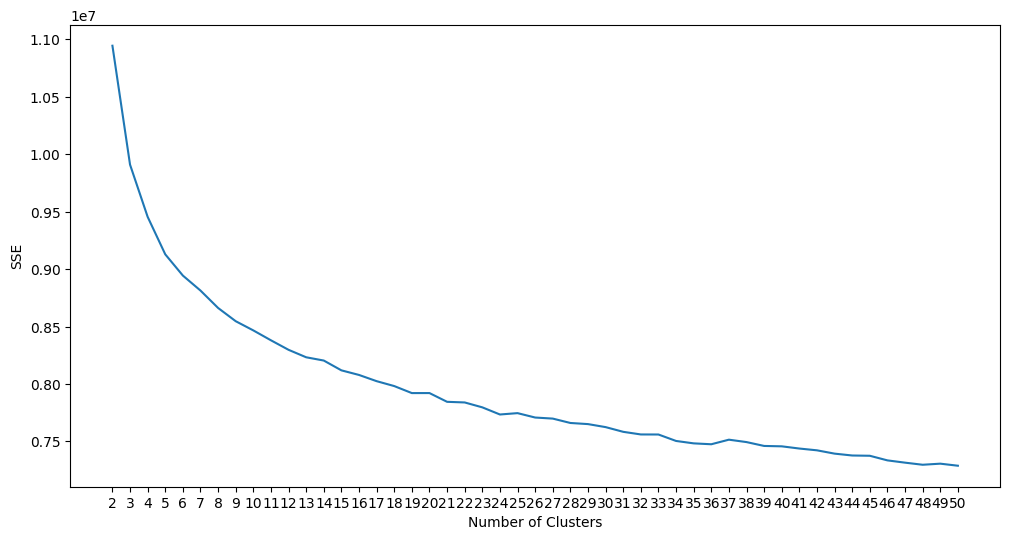

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(range(2, 51), sse)
plt.xticks(range(2, 51))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

"Локоть" не выражен явно на графике. Пусть это будет точка на графике, где касательная к нему наклонена на 135 градусов относительно положительного направления оси абсцисс, т. е. k = 7. Обучим KMeans при 7 кластерах и снова посмотрим на меру "силуэт".

In [58]:
kmeans = KMeans(n_clusters=7, **kmeans_kwargs, algorithm="lloyd")
kmeans.fit(X)
silhouette_score(X, kmeans.labels_)

0.3663780869888747

В целом, результат не сильно поменялся, можно оставить 10 кластеров.

### agglomerative clustering

Иерархическую кластеризацию проведите самостоятельно. В качестве меры сходства возьмите косинусное сходство. Количество кластеров подберите или оцените то же, что подобрали для k-means.

In [59]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering().fit(X)

Для визуализации дендрограммы необходимо сначала вычислить матрицу связей.

In [62]:
import sys
sys.setrecursionlimit(10000)

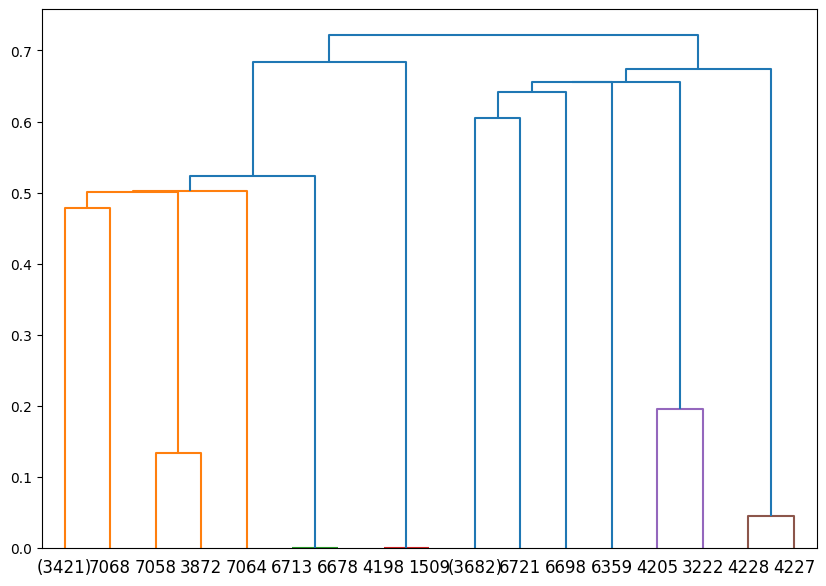

In [69]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X, metric='cosine')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', p=5, truncate_mode='level', show_leaf_counts=True)
plt.show()

Оцените качество кластеризации.

In [61]:
silhouette_score(X, clustering.labels_)

0.33047915325306687

## Поиск "лишних" дисциплин

Эту часть выполните самостоятельно: постройте эмбеддинги для учебных планов по тому же принципу, по которому строили эмбеддинги для дисциплин. Затем проранжируйте все дисциплины в учебном плане по сходству с эмбеддингом плана. Выберите порог для значения сходства, ниже которого дисциплина считается "лишней".


Не нужно оценивать абсолютно все учебные планы из датасета. Можно выбрать около 10 случайных планов или тех, которые вам интересны. И оценить только их.

Обратите внимание, что типичнее для вашей выборки: малое или большое количество "лишних" дисциплин?

Проведите эксперимент: уберите из учебных планов все дисциплины, которые есть в каждом из них. Найдите "лишние" после удаления одинаковых. Оцените результат.

**Выполнение**

В идеале хотелось бы получить текстовое описание учебного плана, список компетенций выпускника и т. д., чтобы сравнивать эмбеддинги дисциплин с эмбеддингом учебного плана, однако в рамках лабораторной работы ограничимся простым усреднением по дисциплинам.

In [10]:
from collections import defaultdict

plan_embeddings = defaultdict(list)

for up_id, group in df.groupby('up_id'):
    embeddings = np.vstack(group['embedding'].values)
    plan_embeddings[up_id] = np.mean(embeddings, axis=0)

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

df['up_embedding'] = df['up_id'].apply(lambda x: plan_embeddings[x])

In [12]:
df.head()

,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding,up_embedding
0,2626,6905,Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[0.04373798, -0.658152, 0.28587788, 0.585062, ...","[-1.5689746643650802, 0.4815729002380953, -0.8..."
1,2626,6938,Философия,bachelor,8.0,Программирование и интернет-технологии,2019,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[0.04373798, -0.658152, 0.28587788, 0.585062, ...","[-1.3955037439694664, 0.5375053836641223, -0.4..."
2,2626,6974,Философия,bachelor,8.0,Информатика и программирование,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[0.04373798, -0.658152, 0.28587788, 0.585062, ...","[-1.5082252463636363, 0.5478488889393941, -0.2..."
3,2626,7014,Философия,bachelor,8.0,Программирование и интернет-технологии,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[0.04373798, -0.658152, 0.28587788, 0.585062, ...","[-1.5562817491499998, 0.5527956907000001, -0.3..."
4,2626,7136,Философия,bachelor,8.0,Информатика и программирование,2021,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[0.04373798, -0.658152, 0.28587788, 0.585062, ...","[-1.320187565593221, 0.4984244228248589, -0.30..."


In [13]:
df['up_course_similarity'] = df.apply(
    lambda row: cosine_similarity([row['embedding']], [row['up_embedding']])[0][0], axis=1
)

Посмотрим на метрику для профильных дисциплин на ИТГС и, например, философии.

In [14]:
df[(df['up_title'] == 'Интеллектуальные системы в гуманитарной сфере') & (df['course_title'] == 'Язык Python для анализа данных')]

,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding,up_embedding,up_course_similarity
5157,4002,6906,Язык Python для анализа данных,bachelor,17.0,Интеллектуальные системы в гуманитарной сфере,2018,"Специализация ""Интеллектуальный анализ данных""",Язык Python для анализа данных. Дисциплина пре...,"['язык', 'python', 'анализ', 'данные', 'дисцип...","[-6.49373889, 1.0, -1.19361103, 1.0, 5.6366252...","[-1.1837066597202797, 0.444868848041958, -0.49...",0.402193
5158,4002,6940,Язык Python для анализа данных,bachelor,17.0,Интеллектуальные системы в гуманитарной сфере,2019,"Специализация ""Интеллектуальный анализ данных""",Язык Python для анализа данных. Дисциплина пре...,"['язык', 'python', 'анализ', 'данные', 'дисцип...","[-6.49373889, 1.0, -1.19361103, 1.0, 5.6366252...","[-1.1057568398203599, 0.5183128020958082, -0.1...",0.373433
14831,10928,7162,Язык Python для анализа данных,bachelor,17.0,Интеллектуальные системы в гуманитарной сфере,2021,"Специализация ""Интеллектуальный анализ данных""",Язык Python для анализа данных. В процессе изу...,"['язык', 'python', 'анализ', 'данные', 'процес...","[-9.7864366, 1.0, -2.0588432, 1.0, 6.0670584, ...","[-1.1482074635545028, 0.5684386343127961, -0.0...",0.437464
34119,15956,7081,Язык Python для анализа данных,bachelor,17.0,Интеллектуальные системы в гуманитарной сфере,2020,"Специализация ""Интеллектуальный анализ данных""",Язык Python для анализа данных. В процессе изу...,"['язык', 'python', 'анализ', 'данные', 'процес...","[-9.7864366, 1.0, -2.0588432, 1.0, 6.0670584, ...","[-1.3329937300975618, 0.561871847902439, -0.00...",0.447255
39006,19149,7247,Язык Python для анализа данных,bachelor,17.0,Интеллектуальные системы в гуманитарной сфере,2022,Факультетский модуль выборных дисциплин (Интел...,Язык Python для анализа данных. Дисциплина пре...,"['язык', 'python', 'анализ', 'данные', 'дисцип...","[-6.49373889, 1.0, -1.19361103, 1.0, 5.6366252...","[-1.3615567739622643, 0.5956110815094341, 0.22...",0.418157


In [15]:
df[(df['up_title'] == 'Интеллектуальные системы в гуманитарной сфере') & (df['course_title'] == 'Философия')]

,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding,up_embedding,up_course_similarity
26984,15101,6906,Философия,bachelor,8.0,Интеллектуальные системы в гуманитарной сфере,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[-0.17024301, -0.46245617, 0.03575841, 0.47169...","[-1.1837066597202797, 0.444868848041958, -0.49...",0.095434
27008,15101,6940,Философия,bachelor,8.0,Интеллектуальные системы в гуманитарной сфере,2019,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[-0.17024301, -0.46245617, 0.03575841, 0.47169...","[-1.1057568398203599, 0.5183128020958082, -0.1...",0.104277
27043,15101,7081,Философия,bachelor,8.0,Интеллектуальные системы в гуманитарной сфере,2020,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[-0.17024301, -0.46245617, 0.03575841, 0.47169...","[-1.3329937300975618, 0.561871847902439, -0.00...",0.080317
27058,15101,7162,Философия,bachelor,8.0,Интеллектуальные системы в гуманитарной сфере,2021,Модуль обязательных дисциплин,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[-0.17024301, -0.46245617, 0.03575841, 0.47169...","[-1.1482074635545028, 0.5684386343127961, -0.0...",0.085132
38830,18980,7247,Философия,bachelor,8.0,Интеллектуальные системы в гуманитарной сфере,2022,Мышление,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[0.04373799, -0.658152, 0.28587788, 0.585062, ...","[-1.3615567739622643, 0.5956110815094341, 0.22...",0.094559


Действительно, профильные дисциплины имеют больший вес, чем непрофильные. Поставим порог вхождения 0.15.

In [16]:
threshold = 0.15

df['is_useful'] = df['up_course_similarity'].apply(lambda x: x >= threshold)

Рассмотрим следующие 10 учебных планов:
*   Интеллектуальные системы в гуманитарной сфере 2020 (id 7081)
*   Интеллектуальные системы в гуманитарной сфере 2021 (id 7162)
*   Интеллектуальные системы в гуманитарной сфере 2022 (id 7247)
*   Управление технологическими инновациями 2021 (id 7087)
*   Бизнес-информатика 2021 (id 7094)
*   Информатика и программирование 2020 (id 6974)
*   Программирование и интернет-технологии 2020 (id 7011)
*   Прикладная и теоретическая физика 2022 (id 7239)
*   Лазерная фотоника и оптоэлектроника 2020 (id 7304)
*   Робототехника и искусственный интеллект 2021 (id 7082)


In [38]:
ups = [7081, 7162, 7247, 7087, 7094, 6974, 7011, 7239, 7304, 7082]

In [36]:
useful_part = df.groupby('up_id')['is_useful'].mean()
useful_part.loc[ups]

up_id
7081    0.541463
7162    0.521327
7247    0.540881
7087    0.531250
7094    0.517857
6974    0.520202
7011    0.445545
7239    0.517857
7304    0.502370
7082    0.472340
Name: is_useful, dtype: float64

Распределение в целом равномерное. Найдём общие "лишние" дисциплины в каждом плане.

In [41]:
useless_disciplines = df[(df['is_useful'] == False) & df['up_id'].isin(ups)]
# сгруппируем по названиям дисциплин и посчитаем количество учебных планов, в которых они встречаются
common_useless_disciplines = useless_disciplines.groupby('course_id').filter(lambda x: len(x) == len(ups))

In [48]:
common_useless_disciplines['course_title'].unique()

array(['Основы финансовой грамотности',
       'Вокальная и танцевальная импровизация',
       'Основы исследовательской деятельности'], dtype=object)

Как можно заметить, это факультативы, мало связанные с будущей профессией выпускника.

Теперь ради эксперимента уберём все общеуниверситетские дисциплины (будем считать общеуниверситетскими те, что встретились во всех учебных планах в выборке) и посмотрим, какие из профильных дисциплин оказались "лишними".

In [55]:
up_samples = df[df['up_id'].isin(ups)]
course_counts = up_samples['course_id'].value_counts()
common_courses = course_counts[course_counts == len(ups)].index
up_samples_no_common = up_samples[~up_samples['course_id'].isin(common_courses)]

In [57]:
up_samples_no_common.groupby('up_id')['is_useful'].mean()

up_id
6974    0.523316
7011    0.447917
7081    0.545000
7082    0.473913
7087    0.534247
7094    0.520548
7162    0.524272
7239    0.523364
7247    0.545455
7304    0.504854
Name: is_useful, dtype: float64

Распределение изменилось незначительно, поскольку общих дисциплин в выборке оказалось немного. Это могло быть связано с тем, что для анализа были взяты диаметрально противоположные факультеты: от ФИТИПа до ФТМИ.

## Генерация содержания

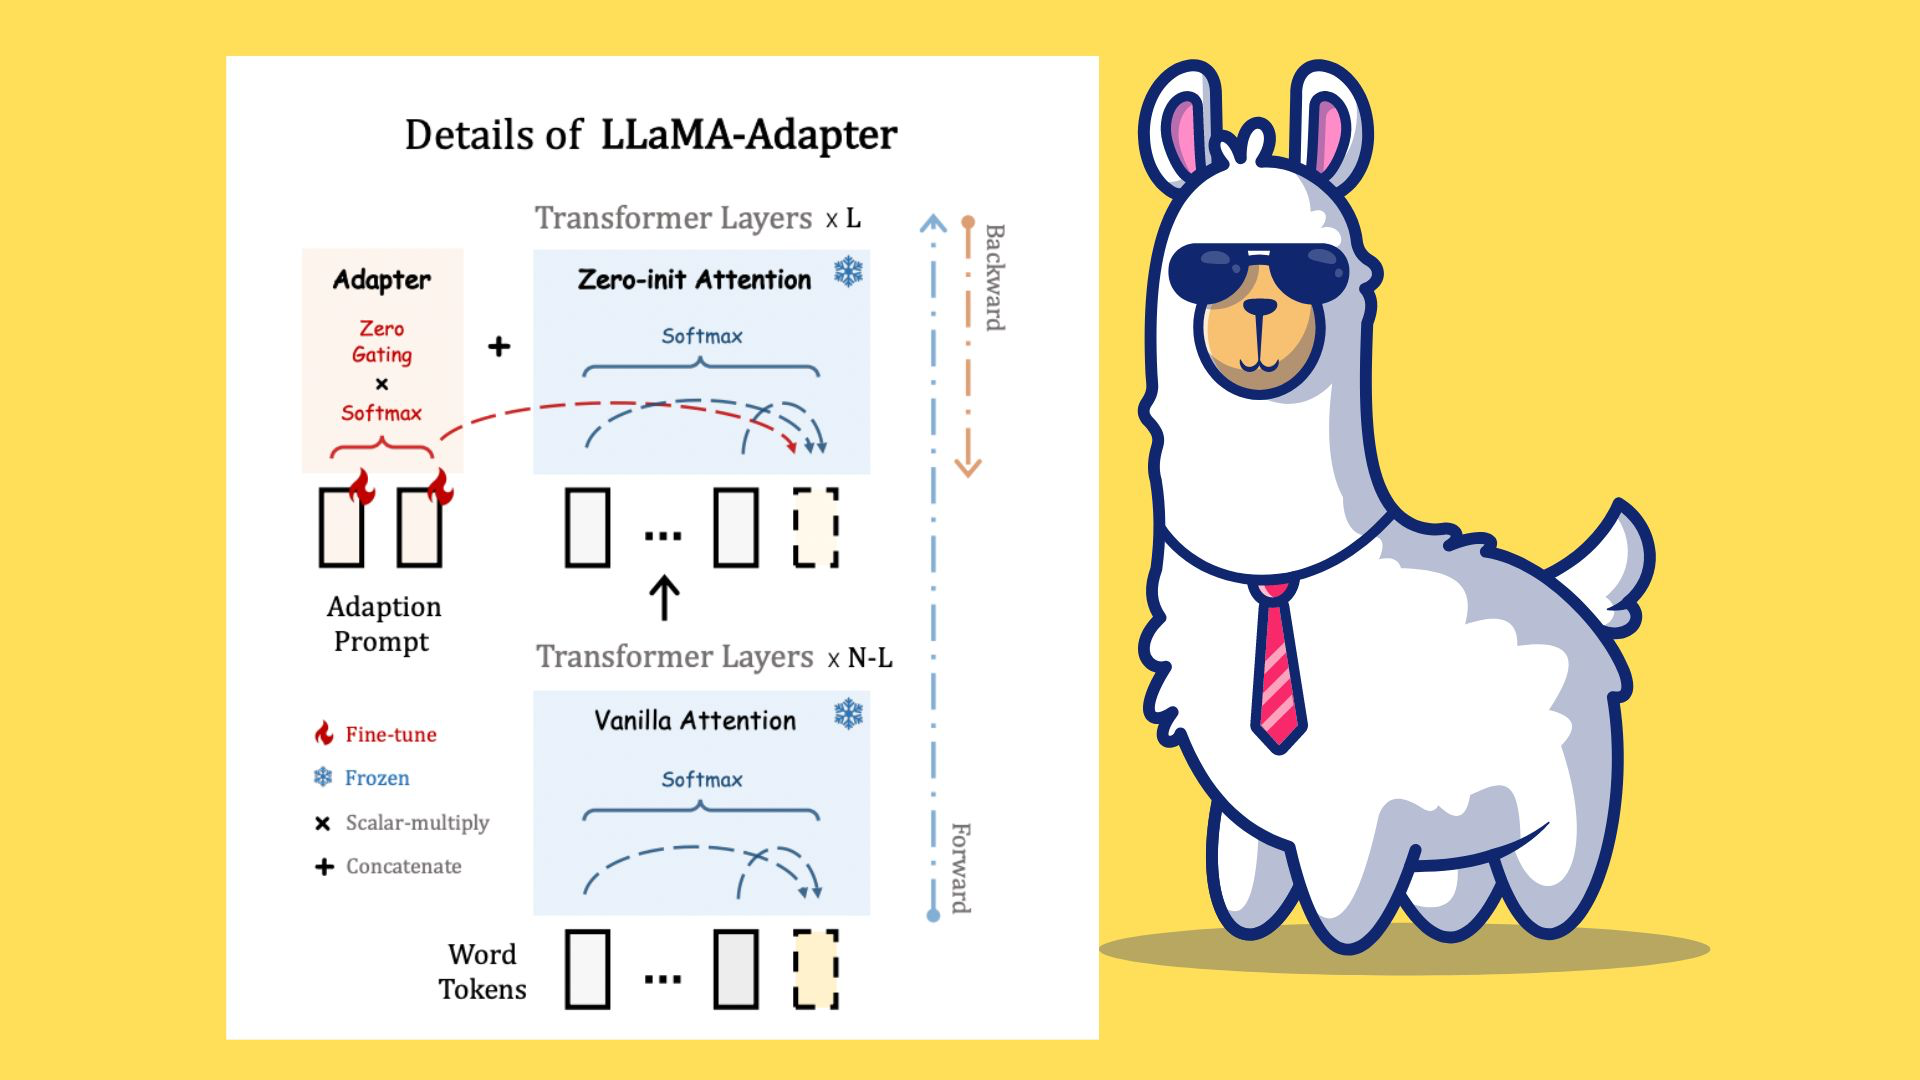

В этой части работы вам предлагается повторить пайплайн дообучения модели [LLaMA](https://github.com/facebookresearch/llama) (LLM с открытым исходным кодом) из туториала: https://colab.research.google.com/drive/1tG9eqttfnqHoQqmsiacywUG9ilUhoiCk?usp=sharing#scrollTo=qL5i358PRGgu

С текстовым описанием: https://www.datacamp.com/tutorial/fine-tuning-llama-2

Обзор с Хабра: https://habr.com/ru/articles/755114/

Если памяти или ресурсов колаба не хватит, то попробуйте без дообучения. Но результат будет хуже.

Выберите 10-15 дисциплин (случайных или интересных вам) и с помощью модели сгенерируйте возможное описание дисциплины.

Постройте эмбеддинг для полученного описания. Оцените близость полученного эмбеддинга и того, что у вас уже был с момента создания word2vec.

Среди выбранных вами дисциплин найдите те, которые реализуются больше одного года. Изучите их следующим образом:

1. Оцените, насколько содержательно близки дисциплины разных лет.
2. Оцените, к дисциплине какого года ближе всего сгенерированное содержание.

**Выполнение**

Зададим формат промпта и результата, на которых будем обучать модель.

In [8]:
prompt = "<s>[INST] Ты — языковая модель, помогающая преподавателям писать описания для дисциплин университета ИТМО. Сгенерируй описание для дисциплины %s [/INST] %s"

Далее дообучим модель.

In [7]:
%%capture
%pip install accelerate peft bitsandbytes transformers trl datasets

In [9]:
# Файнтюнинг
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [10]:
base_model = "NousResearch/Llama-2-7b-chat-hf"

In [13]:
prepared_dataset = df_to_clust.apply(lambda row: prompt % (row['course_title'], row['full_description']), axis=1)
prepared_dataset = pd.DataFrame(prepared_dataset, columns=['text'])
prepared_dataset.to_csv('prepared_for_llama.csv', index=False)

dataset = load_dataset('csv', data_files='prepared_for_llama.csv', split='train')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [11]:
compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

In [12]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0}
)
model.config.use_cache = False
model.config.pretraining_tp = 1

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [15]:
# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [17]:
# Load LoRA configuration
peft_args = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

In [18]:
# Set training parameters
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

In [19]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_args,
    dataset_text_field="text",
    max_seq_length=None,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:194: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/7118 [00:00<?, ? examples/s]

In [20]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


OutOfMemoryError: ignored

Увы и ах. Попробуем без дообучения.

In [24]:
logging.set_verbosity(logging.CRITICAL)

prompt = "<s>[INST] Ты — языковая модель, помогающая преподавателям писать описания для дисциплин университета ИТМО. Сгенерируй описание для дисциплины %s. Твой ответ не должен содержать ничего, кроме самого описания. [/INST]"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=500)
result = pipe(prompt % "Философия")
print(result[0]['generated_text'])

<s>[INST] Ты — языковая модель, помогающая преподавателям писать описания для дисциплин университета ИТМО. Сгенерируй описание для дисциплины Философия. Твой ответ не должен содержать ничего, кроме самого описания. [/INST]  Конечно! Вот описание для дисциплины "Философия":

"Философия - это дисциплина, которая изучает основные вопросы и проблемы философской мысли. Она рассматривает вопросы, связанные с пониманием и объяснением истины, морали, бытия, сознания и других философских тем. В рамках этой дисциплины преподаватели и студенты изучают различные философские теории и идеи, а также анализируют их влияние на нашу жизнь и общество. Она помогает студентам развивать критическое мышление, понимание различных точек зрения и способность мыслить на глубоком уровне. В результате, студенты могут лучше понимать мир вокруг них и находить свой путь в жизни."


В целом, результат выглядит приемлемо. Дополним наш датасет описаниями, сгенерированными LLM.

In [21]:
samples = df_to_clust[:10]

In [22]:
samples

,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding
0,2626,6905,Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[0.04373798, -0.658152, 0.28587788, 0.585062, ..."
6,2627,7146,Введение в цифровую культуру и программирование,bachelor,14.0,Программирование и интернет-технологии,2021,Модуль обязательных дисциплин,Введение в цифровую культуру и программировани...,"['введение', 'цифровой', 'культура', 'программ...","[0.00798363, 0.6213324, -0.19811843, 0.660143,..."
7,2628,6881,Проектирование баз данных,bachelor,14.0,Информатика и программирование,2018,Модуль «Цифровая культура»,Проектирование баз данных. Дисциплина направле...,"['проектирование', 'база', 'данные', 'дисципли...","[-1.17156541, 0.0, -9.6684742, 1.0, 7.97932923..."
11,2631,6881,Современные вопросы информатики,bachelor,14.0,Информатика и программирование,2018,Модуль «Цифровая культура»,Современные вопросы информатики. Дисциплина на...,"['современный', 'вопрос', 'информатика', 'дисц...","[-3.5235849, 1.0, 1.87303796, 1.0, -9.95470732..."
14,2635,6859,Иностранный язык,bachelor,9.0,Нанофотоника и квантовая оптика,2018,Модуль «Soft Skills»,Иностранный язык. Целью освоения дисциплины яв...,"['иностранный', 'язык', 'цель', 'освоение', 'д...","[3.90069366, 1.0, 3.66938591, 1.0, -7.29892254..."
91,2637,6859,"Техники публичных выступлений, переговоров и п...",bachelor,22.0,Нанофотоника и квантовая оптика,2018,Модуль «Soft Skills»,"Техники публичных выступлений, переговоров и п...","['техника', 'публичный', 'выступление', 'перег...","[-5.16883552, 1.0, 8.97972286, 1.0, 2.53033578..."
133,2640,6859,Теория автоматического управления,bachelor,2.0,Нанофотоника и квантовая оптика,2018,ОГНП 2: Киберфизические системы и технологи,Теория автоматического управления. Дисциплина ...,"['теория', 'автоматический', 'управление', 'ди...","[-6.3736284, 1.0, -1.257786, 0.0, -2.6064622, ..."
249,2641,6859,Основы проектирования киберфизических систем,bachelor,2.0,Нанофотоника и квантовая оптика,2018,ОГНП 2: Киберфизические системы и технологи,Основы проектирования киберфизических систем. ...,"['основа', 'проектирование', 'киберфизический'...","[0.06807503, 0.64313513, -0.02181049, 0.393551..."
365,2642,6859,Методы и средства программного обеспечения,All_levels,12.0,Нанофотоника и квантовая оптика,2018,ОГНП 3: Компьютерные технологии,Методы и средства программного обеспечения. Ди...,"['метод', 'средство', 'программный', 'обеспече...","[-3.8294366, 1.0, -4.10243943, 2.0, 1.1394912,..."
485,2643,6859,Основы кибербезопасности,bachelor,13.0,Нанофотоника и квантовая оптика,2018,ОГНП 3: Компьютерные технологии,Основы кибербезопасности. В данном курсе студе...,"['основа', 'кибербезопасность', 'данный', 'кур...","[-0.60786223, -0.6022366, -0.76277995, 0.26275..."


In [25]:
from tqdm.auto import tqdm
tqdm.pandas()

def generate_description(course_title):
    text = prompt % course_title
    result = pipe(text)[0]['generated_text']
    return result.split('[/INST]')[1].strip()

samples['generated_description'] = samples['course_title'].progress_apply(generate_description)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
<ipython-input-25-c644b86eab04>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['generated_description'] = samples['course_title'].progress_apply(generate_description)


In [27]:
samples.to_csv("generated_descriptions.csv", index=False)

In [40]:
samples['generated_description']

0    Конечно! Вот описание для дисциплины "Философи...
1    Конечно! Вот описание для дисциплины "Введение...
2    Конечно! Вот описание для дисциплины "Проектир...
3    Sure, I'd be happy to help! Here is a possible...
4    Конечно! Вот описание для дисциплины "Иностран...
5    Title: Techniques of Public Speaking, Negotiat...
6    Конечно! Вот описание для дисциплины Теория ав...
7    Конечно! Вот описание для дисциплины "Основы п...
8    Конечно! Вот описание для дисциплины "Методы и...
9    Конечно! Вот описание для дисциплины "Основы к...
Name: generated_description, dtype: object

Произведём предобработку, векторизацию на основе обученной модели Word2Vec и оценим косинусное сходство полученных описаний.

In [54]:
samples['processed_generated_description'] = samples['generated_description'].apply(text_to_wordlist)

In [57]:
from gensim.models import Word2Vec

w2v_model = Word2Vec.load("op_w2v")
samples['generated_embedding'] = samples['processed_generated_description'].apply(lambda x: embed(x, w2v_model))

samples.to_csv("generated_description_embeddings.csv", index=False)

In [60]:
samples.head(3)

,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding,generated_description,processed_generated_description,generated_embedding
0,2626,6905,Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[0.04373798, -0.658152, 0.28587788, 0.585062, ...","Конечно! Вот описание для дисциплины ""Философи...","[описание, дисциплина, философия, философия, э...","[-0.29238132, 0.9969587, -0.06274157, 0.039001..."
1,2627,7146,Введение в цифровую культуру и программирование,bachelor,14.0,Программирование и интернет-технологии,2021,Модуль обязательных дисциплин,Введение в цифровую культуру и программировани...,"['введение', 'цифровой', 'культура', 'программ...","[0.00798363, 0.6213324, -0.19811843, 0.660143,...","Конечно! Вот описание для дисциплины ""Введение...","[описание, дисциплина, введение, цифровой, кул...","[0.32466394, 1.2344116, -0.609868, 0.6395327, ..."
2,2628,6881,Проектирование баз данных,bachelor,14.0,Информатика и программирование,2018,Модуль «Цифровая культура»,Проектирование баз данных. Дисциплина направле...,"['проектирование', 'база', 'данные', 'дисципли...","[-1.17156541, 0.0, -9.6684742, 1.0, 7.97932923...","Конечно! Вот описание для дисциплины ""Проектир...","[описание, дисциплина, проектирование, база, д...","[-0.58748525, 0.4211452, 0.6844509, 0.58280414..."


In [63]:
from sklearn.metrics.pairwise import cosine_similarity

samples['natural_generated_similarity'] = samples.apply(
    lambda row: cosine_similarity([row['embedding']], [row['generated_embedding']])[0][0], axis=1
)

In [64]:
samples

,course_id,up_id,course_title,qualification,unit_id,up_title,start_year,module_name,full_description,processed_description,embedding,generated_description,processed_generated_description,generated_embedding,natural_generated_similarity
0,2626,6905,Философия,bachelor,8.0,Программирование и интернет-технологии,2018,Модуль «Философия+Мышление»,Философия. Курс «Философия» даёт целостное пре...,"['философия', 'курс', 'философия', 'давать', '...","[0.04373798, -0.658152, 0.28587788, 0.585062, ...","Конечно! Вот описание для дисциплины ""Философи...","[описание, дисциплина, философия, философия, э...","[-0.29238132, 0.9969587, -0.06274157, 0.039001...",0.489145
1,2627,7146,Введение в цифровую культуру и программирование,bachelor,14.0,Программирование и интернет-технологии,2021,Модуль обязательных дисциплин,Введение в цифровую культуру и программировани...,"['введение', 'цифровой', 'культура', 'программ...","[0.00798363, 0.6213324, -0.19811843, 0.660143,...","Конечно! Вот описание для дисциплины ""Введение...","[описание, дисциплина, введение, цифровой, кул...","[0.32466394, 1.2344116, -0.609868, 0.6395327, ...",0.775402
2,2628,6881,Проектирование баз данных,bachelor,14.0,Информатика и программирование,2018,Модуль «Цифровая культура»,Проектирование баз данных. Дисциплина направле...,"['проектирование', 'база', 'данные', 'дисципли...","[-1.17156541, 0.0, -9.6684742, 1.0, 7.97932923...","Конечно! Вот описание для дисциплины ""Проектир...","[описание, дисциплина, проектирование, база, д...","[-0.58748525, 0.4211452, 0.6844509, 0.58280414...",-0.139363
3,2631,6881,Современные вопросы информатики,bachelor,14.0,Информатика и программирование,2018,Модуль «Цифровая культура»,Современные вопросы информатики. Дисциплина на...,"['современный', 'вопрос', 'информатика', 'дисц...","[-3.5235849, 1.0, 1.87303796, 1.0, -9.95470732...","Sure, I'd be happy to help! Here is a possible...","[sure, happy, help, possible, oversight, cours...","[0.9467783, -1.1315413, 0.11881674, 0.12145651...",0.011849
4,2635,6859,Иностранный язык,bachelor,9.0,Нанофотоника и квантовая оптика,2018,Модуль «Soft Skills»,Иностранный язык. Целью освоения дисциплины яв...,"['иностранный', 'язык', 'цель', 'освоение', 'д...","[3.90069366, 1.0, 3.66938591, 1.0, -7.29892254...","Конечно! Вот описание для дисциплины ""Иностран...","[описание, дисциплина, иностранный, язык, дисц...","[0.31997132, 1.3352236, 0.14245737, -0.3929492...",0.097106
5,2637,6859,"Техники публичных выступлений, переговоров и п...",bachelor,22.0,Нанофотоника и квантовая оптика,2018,Модуль «Soft Skills»,"Техники публичных выступлений, переговоров и п...","['техника', 'публичный', 'выступление', 'перег...","[-5.16883552, 1.0, 8.97972286, 1.0, 2.53033578...","Title: Techniques of Public Speaking, Negotiat...","[title, techniques, public, speaking, negotiat...","[0.5759969, -0.73997366, 0.489903, 0.699511, 0...",-0.055254
6,2640,6859,Теория автоматического управления,bachelor,2.0,Нанофотоника и квантовая оптика,2018,ОГНП 2: Киберфизические системы и технологи,Теория автоматического управления. Дисциплина ...,"['теория', 'автоматический', 'управление', 'ди...","[-6.3736284, 1.0, -1.257786, 0.0, -2.6064622, ...",Конечно! Вот описание для дисциплины Теория ав...,"[описание, дисциплина, теория, автоматический,...","[-0.44815782, 0.15847449, -0.24132136, -0.0221...",0.005493
7,2641,6859,Основы проектирования киберфизических систем,bachelor,2.0,Нанофотоника и квантовая оптика,2018,ОГНП 2: Киберфизические системы и технологи,Основы проектирования киберфизических систем. ...,"['основа', 'проектирование', 'киберфизический'...","[0.06807503, 0.64313513, -0.02181049, 0.393551...","Конечно! Вот описание для дисциплины ""Основы п...","[описание, дисциплина, основа, проектирование,...","[-0.24956268, 0.65310323, -0.11662786, 1.00285...",0.765166
8,2642,6859,Методы и средства программного обеспечения,All_levels,12.0,Нанофотоника и квантовая оптика,2018,ОГНП 3: Компьютерные технологии,Методы и средства программного обеспечения. Ди.

По косинусному сходству, не зафайнтюненная LLM смога сгенерировать близкие описания в 4/10 случаях (Философия, Введение в цифровую культуру и программирование, Основы проектирования киберфизических систем, Основы кибербезопасности).